<a href="https://colab.research.google.com/github/moze90/Thesis2022/blob/main/master_Thesis_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

.0
# Data Collection and Coversion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")
from glob import glob
import re
import gc
import csv
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix
from pandas.io.parsers.readers import read_csv
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
! gdown 1-7jNiUiBVs907NQMMQHHucu46IKrlm7O

Downloading...
From: https://drive.google.com/uc?id=1-7jNiUiBVs907NQMMQHHucu46IKrlm7O
To: /content/Fraga1.csv
100% 13.6M/13.6M [00:00<00:00, 76.5MB/s]


In [3]:
df = (r"/content/Fraga1.csv")
print(df)

/content/Fraga1.csv


-**Equip.reg_date**:Date when the equipment was registered

-**Scrapped_date**	:Date when the equipment was scrapped. NULL means it is not scrapped.

**Cost**:The purchase cost of the equipment, excluding all equipment costing less than 10 000 SEK

**dev.** device type 

**Brand**:brand of the device

**Model: model**

**calc.Risk**
The calculated risk based on PMFU.

**Latest_WO**The latest completed work order.

**Count_WO**Total number of work orders performed since start.

**Meantime** meantime between work orders.

**Latest_PM** latest performed preventive maintenance.

**Count_PM**Total number of preventive maintenance performed since start.

**Meantime_PM** Meantime between preventive maintenance.

**V1**The number of times pm completed * from the scheduled time. (* < 29 days)

**V2**The number of times pm completed * from the scheduled time. (* 29=<, >=89 days)

**V3**The number of times pm completed * from the scheduled time. (* 90=< days) 

## DATA PRE-PROCESSING

**Load data and change columns names**
sparse date argument to change dates in datetime objects so we can use it later 



In [4]:
data2 = pd.read_csv(df,sep=';',encoding='cp1252',header=0)
data2.head(5)

,InkDat,Skrotad,SkrotDatum,flPurchaseCost,Benamn,Fabrikat,Modell,Handelsnamn,intRisktal,ID,Latest,Count_WO,Meantime,Latest_PM,count_PM,Meantime_PM,V1,V2,V3
0,2010-01-01 00:00:00.000,2,NaN,75000,Operationslampa,Admeco,Admeco Lux GSI,NaN,31,100010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-01 00:00:00.000,0,NaN,74000,Endoskopi-Intubationsskop,Vingmed,Vingmed FI-10RBS,NaN,20,100011,2019-6-27 00:00:00,5.0,676.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-01 00:00:00.000,2,NaN,19800,Laryngoskope stelt intubation,Storz,8706CA,NaN,31,100015,2010-3-24 00:00:00,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-01 00:00:00.000,2,NaN,19800,Laryngoskope stelt intubation,Storz,8706CA,NaN,31,100016,2010-3-24 00:00:00,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-01 00:00:00.000,2,NaN,20000,Video Nystagmoskop,Atos Medical AB,SY-VNS 3x,NaN,31,100018,2010-3-25 00:00:00,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
new_names = ['Equip.reg_date', 'skrodat', 'Scrapped_date', 'Cost', 'dev','Brand','Model','Handelsnamn','cal.Risk','ID','Latest_WO','Count_WO','Meantime','Latest_PM','Count_PM','Meantime_PM','V1','V2','V3']
data2 = pd.read_csv(df,sep=';',encoding='cp1252',header=0,names=new_names,parse_dates=['Equip.reg_date','Scrapped_date', 'Latest_WO', 'Latest_PM'])

**DROP 3 irrelevant columns **

In [6]:
data=data2.drop(columns=['skrodat','ID','Handelsnamn'])

In [7]:
len(data)

87239

In [8]:
data.shape

(87239, 16)

this is the  completer number of row we have from source 87000 rows.

DATA Cleaning **Handling missing vlaues**

In [9]:
data.isna().sum()

Equip.reg_date      947
Scrapped_date     57763
Cost                  0
dev                  32
Brand                32
Model                52
cal.Risk              0
Latest_WO         27813
Count_WO          27813
Meantime          27813
Latest_PM         39774
Count_PM          39774
Meantime_PM       39774
V1                39774
V2                39774
V3                39774
dtype: int64

we can see that we have almost 40000 rows has missing data in it ,so we need to filter out this for the machine learning model. the missing data is in columns which are really crucial to our analysis so , I guess we need to remove them due to the high volume of data we have.

In [10]:
data.shape

(87239, 16)

## **Imputations Techniques**

**scrapped date handling**

In [11]:
data.dropna(axis=0 ,inplace = True)

we have got 13000 samples with no null values, I think we can start and see what we will get.

In [12]:
len(data)

13407

Adding new columns which represents the the device age , it is a difference between equipment reg date and scrapped date columns

In [13]:
data["age"]=(data["Scrapped_date"]-data["Equip.reg_date"]).dt.days


In [14]:
data.head(3)

,Equip.reg_date,Scrapped_date,Cost,dev,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age
14,2009-01-01,2019-03-12,390000,Anestesiarbetsstation,Dräger,Primus,31,2010-04-07,1.0,0.0,2015-05-07,1.0,0.0,1.0,0.0,0.0,3722
18,2009-01-01,2019-03-12,390000,Anestesiarbetsstation,Dräger,Primus,31,2015-05-11,4.0,465.0,2016-05-30,2.0,209.0,2.0,0.0,0.0,3722
32,2010-01-01,2019-10-01,100000,Patientmonitor multiparameter,Dräger,Infinity Delta,31,2019-09-25,6.0,111.0,2017-12-18,1.0,0.0,1.0,0.0,0.0,3560


Use device type as a row index of the dataframe

In [15]:
data = data.set_index('dev')
data.head(3)

,Equip.reg_date,Scrapped_date,Cost,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age
dev,,,,,,,,,,,,,,,,
Anestesiarbetsstation,2009-01-01,2019-03-12,390000,Dräger,Primus,31,2010-04-07,1.0,0.0,2015-05-07,1.0,0.0,1.0,0.0,0.0,3722
Anestesiarbetsstation,2009-01-01,2019-03-12,390000,Dräger,Primus,31,2015-05-11,4.0,465.0,2016-05-30,2.0,209.0,2.0,0.0,0.0,3722
Patientmonitor multiparameter,2010-01-01,2019-10-01,100000,Dräger,Infinity Delta,31,2019-09-25,6.0,111.0,2017-12-18,1.0,0.0,1.0,0.0,0.0,3560


**Filter rows by device type **
Anestesiarbetsstation, Modul till anestesiarbetsstation, (Anestesimedelsförgasare, isofluran)21 samples,  Anestesimedel Förgasare , Anestesiapparat mobil=55samples, Lungventilator anestesi-39samples

In [16]:
data01=data.query("dev == 'Oxygenkoncentrator stationär'")
len(data01)



619

In [17]:
data01.head(3)

,Equip.reg_date,Scrapped_date,Cost,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age
dev,,,,,,,,,,,,,,,,
Oxygenkoncentrator stationär,2003-01-01,2011-09-13,12000,DeVilbiss,515,31,2011-09-12,4.0,331.0,2010-02-08,1.0,0.0,1.0,0.0,0.0,3177
Oxygenkoncentrator stationär,2006-01-01,2012-09-24,13000,Respironics,Millennium M5,31,2012-09-24,7.0,236.0,2011-07-05,1.0,0.0,1.0,0.0,0.0,2458
Oxygenkoncentrator stationär,2004-01-01,2013-06-05,14500,Respironics,Millennium M5,31,2013-06-05,6.0,289.0,2011-07-18,1.0,0.0,1.0,0.0,0.0,3443


In [18]:
data02=data.query("dev == 'Patientmonitor multiparameter'")
data02.head(5)
len(data02)

1090

**Exploratory Data Analysis (EDA)**

**General insights about all devices data combined**

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13407 entries, Anestesiarbetsstation to Infusionspump, volym
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Equip.reg_date  13407 non-null  datetime64[ns]
 1   Scrapped_date   13407 non-null  datetime64[ns]
 2   Cost            13407 non-null  int64         
 3   Brand           13407 non-null  object        
 4   Model           13407 non-null  object        
 5   cal.Risk        13407 non-null  int64         
 6   Latest_WO       13407 non-null  datetime64[ns]
 7   Count_WO        13407 non-null  float64       
 8   Meantime        13407 non-null  float64       
 9   Latest_PM       13407 non-null  datetime64[ns]
 10  Count_PM        13407 non-null  float64       
 11  Meantime_PM     13407 non-null  float64       
 12  V1              13407 non-null  float64       
 13  V2              13407 non-null  float64       
 14  V3              13407 no

In [20]:
data.describe()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
count,1.340700e+04,13407.000000,13407.000000,13407.000000,13407.000000,13407.000000,13407.000000,13407.000000,13407.000000,13407.000000
mean,1.050392e+05,27.767062,7.356456,429.593645,3.595734,228.663534,2.931901,0.090550,0.573283,4484.737749
std,5.848931e+05,5.737595,16.088655,434.371012,5.149987,220.764763,4.378150,0.396922,1.697902,3432.090495
min,1.005000e+04,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-37985.000000
25%,1.800000e+04,26.000000,2.000000,121.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2880.000000
50%,2.540000e+04,31.000000,4.000000,328.000000,2.000000,237.000000,2.000000,0.000000,0.000000,4038.000000
75%,6.900000e+04,31.000000,8.000000,597.000000,5.000000,377.000000,4.000000,0.000000,1.000000,5454.000000
max,2.725000e+07,32.000000,591.000000,3848.000000,108.000000,1566.000000,98.000000,12.000000,54.000000,44529.000000


We can see the following from this

1-Meantime between every preventive maintenance and the other is **228 days which makes 7 months and 3 weeks.**

2-Mean time between every work order and the other is **429 days which makes 14 months and 10 days**

average anesthia device age 12 years old 

@vipin , THIS is your photo for point no.1
there is no correlations between all devices data

In [21]:
data.corr()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
Cost,1.000000,-0.018828,0.410945,-0.068941,0.102189,-0.022222,0.107870,0.097183,0.009085,-0.000767
cal.Risk,-0.018828,1.000000,-0.042246,-0.050186,-0.148135,-0.231681,-0.192582,-0.046321,0.058096,0.072110
Count_WO,0.410945,-0.042246,1.000000,-0.128497,0.104157,0.070947,0.121728,0.044834,-0.008440,0.009998
Meantime,-0.068941,-0.050186,-0.128497,1.000000,0.078794,0.181810,0.077938,0.038993,0.028911,0.108234
Count_PM,0.102189,-0.148135,0.104157,0.078794,1.000000,0.177091,0.946277,0.172341,0.552822,0.021193
Meantime_PM,-0.022222,-0.231681,0.070947,0.181810,0.177091,1.000000,0.237544,0.067892,-0.091251,-0.022434
V1,0.107870,-0.192582,0.121728,0.077938,0.946277,0.237544,1.000000,0.118415,0.263953,-0.000466
V2,0.097183,-0.046321,0.044834,0.038993,0.172341,0.067892,0.118415,1.000000,-0.016377,0.058755
V3,0.009085,0.058096,-0.008440,0.028911,0.552822,-0.091251,0.263953,-0.016377,1.000000,0.051747
age,-0.000767,0.072110,0.009998,0.108234,0.021193,-0.022434,-0.000466,0.058755,0.051747,1.000000


@vipin , these are describing data about anaesthia device alone , so in the data the average time between faults WO 350 day but I will take 249 days as a reference as it represents 50 percentile of data ,each value that less than 249 will be considered unhealty and preventive maintenance activities needs to be changed accordingly

the meantime between work orders in the anasthezia devices is 350 days ,we have more that 50% percentile of data under 249 days , we will add each device 249 to the class called (called-Revise_PM =1) Unhealthy and the other class called Healthy 0

In [22]:
data02.describe()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
count,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,70912.419266,26.109174,4.506422,484.468807,5.241284,255.358716,4.167890,0.131193,0.942202,4268.927523
std,59407.945689,6.539560,3.832879,461.350892,10.261214,195.863328,6.165328,0.441468,4.754907,1874.673809
min,10650.000000,17.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,772.000000
25%,39536.500000,17.000000,2.000000,128.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3019.000000
50%,62000.000000,31.000000,4.000000,411.000000,4.000000,283.000000,3.000000,0.000000,0.000000,3943.000000
75%,89500.000000,31.000000,6.000000,700.000000,6.000000,380.750000,5.000000,0.000000,1.000000,5242.000000
max,915417.000000,32.000000,42.000000,3143.000000,106.000000,985.000000,52.000000,3.000000,54.000000,13609.000000


In [23]:
data02.corr()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
Cost,1.000000,-0.059061,0.153164,0.010612,0.020435,0.063579,0.006950,-0.055786,0.040266,-0.102760
cal.Risk,-0.059061,1.000000,0.000467,-0.003627,0.050034,-0.318673,-0.000706,0.078687,0.101584,0.278074
Count_WO,0.153164,0.000467,1.000000,0.015472,0.195931,0.209614,0.231806,-0.031160,0.125153,0.169208
Meantime,0.010612,-0.003627,0.015472,1.000000,0.060633,0.186390,0.093484,0.091858,0.001106,0.181253
Count_PM,0.020435,0.050034,0.195931,0.060633,1.000000,-0.004700,0.954084,0.051589,0.916148,0.065814
Meantime_PM,0.063579,-0.318673,0.209614,0.186390,-0.004700,1.000000,0.098121,0.050983,-0.142103,-0.067314
V1,0.006950,-0.000706,0.231806,0.093484,0.954084,0.098121,1.000000,0.054315,0.757270,0.041052
V2,-0.055786,0.078687,-0.031160,0.091858,0.051589,0.050983,0.054315,1.000000,-0.051941,0.085226
V3,0.040266,0.101584,0.125153,0.001106,0.916148,-0.142103,0.757270,-0.051941,1.000000,0.080886
age,-0.102760,0.278074,0.169208,0.181253,0.065814,-0.067314,0.041052,0.085226,0.080886,1.000000


** testing general assumptions a about data**

data 01 are oxygen concentrators

Assumption 1 : V3,V2,V1 and their relationship with  Count of work orders , either in general or device specific

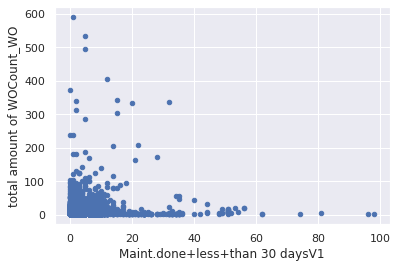

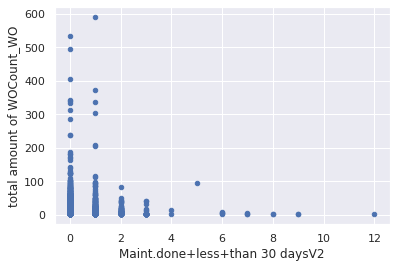

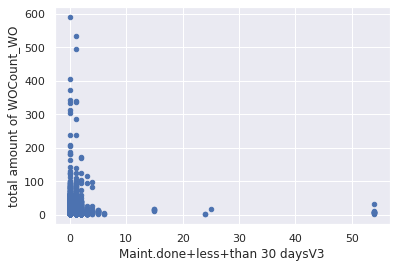

In [24]:
data.plot(x ='V1', y='Count_WO', kind = 'scatter',xlabel='Maint.done+less+than 30 daysV1',
    ylabel='total amount of WOCount_WO')	
data.plot(x ='V2', y='Count_WO', kind = 'scatter',xlabel='Maint.done+less+than 30 daysV2',
    ylabel='total amount of WOCount_WO')	
data.plot(x ='V3', y='Count_WO', kind = 'scatter',xlabel='Maint.done+less+than 30 daysV3',
    ylabel='total amount of WOCount_WO')	

## ** Anesthesia-device experiements**

In [25]:
data2=data.query("dev == 'Anestesiarbetsstation'")
data3=data.query("dev == 'Modul till anestesiarbetsstation'")
data4=data.query("dev == 'Anestesimedelsförgasare, isofluran'")
data5=data.query("dev == 'Anestesimedel Förgasare'")
data6=data.query("dev == 'Anestesiapparat mobil'")
data7=data.query("dev == 'Lungventilator anestesi'")
data_anes = pd.concat([data2, data3, data4, data5, data6, data7], axis=0)
data_anes.head(3)
 

,Equip.reg_date,Scrapped_date,Cost,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age
dev,,,,,,,,,,,,,,,,
Anestesiarbetsstation,2009-01-01,2019-03-12,390000,Dräger,Primus,31,2010-04-07,1.0,0.0,2015-05-07,1.0,0.0,1.0,0.0,0.0,3722
Anestesiarbetsstation,2009-01-01,2019-03-12,390000,Dräger,Primus,31,2015-05-11,4.0,465.0,2016-05-30,2.0,209.0,2.0,0.0,0.0,3722
Anestesiarbetsstation,2010-01-01,2018-01-16,375000,GE Healthcare,ADU,31,2015-11-23,2.0,1004.0,2016-12-12,7.0,297.0,6.0,0.0,1.0,2937


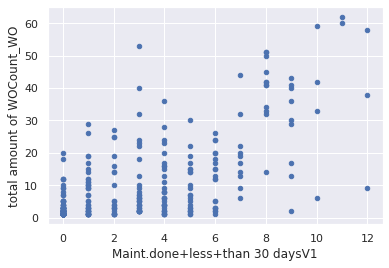

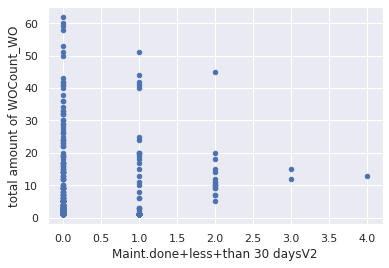

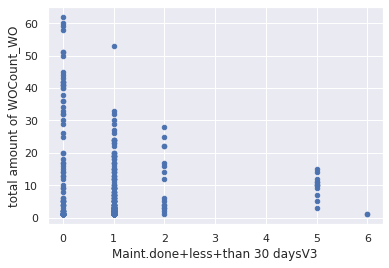

In [26]:
data_anes.plot(x ='V1', y='Count_WO', kind = 'scatter',xlabel='Maint.done+less+than 30 daysV1',
    ylabel='total amount of WOCount_WO')	
data_anes.plot(x ='V2', y='Count_WO', kind = 'scatter',xlabel='Maint.done+less+than 30 daysV2',
    ylabel='total amount of WOCount_WO')	
data_anes.plot(x ='V3', y='Count_WO', kind = 'scatter',xlabel='Maint.done+less+than 30 daysV3',
    ylabel='total amount of WOCount_WO')

In [27]:
data_anes.describe()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,150346.934426,30.750820,10.354098,350.891803,4.144262,209.170492,2.875410,0.318033,0.950820,7962.947541
std,162165.661124,0.503482,12.853394,378.951407,3.018393,174.833954,2.989711,0.633886,1.067249,9707.054227
min,12000.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,910.000000
25%,22500.000000,31.000000,2.000000,68.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4038.000000
50%,32700.000000,31.000000,4.000000,249.000000,4.000000,269.000000,2.000000,0.000000,1.000000,5494.000000
75%,295000.000000,31.000000,14.000000,528.000000,7.000000,336.000000,5.000000,0.000000,1.000000,6773.000000
max,682857.000000,31.000000,62.000000,2058.000000,12.000000,859.000000,12.000000,4.000000,6.000000,43492.000000


In [28]:
data_anes["Label"]= np.where(data_anes['Meantime']<=249, 1, 0)
data_anes.head(5)

,Equip.reg_date,Scrapped_date,Cost,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age,Label
dev,,,,,,,,,,,,,,,,,
Anestesiarbetsstation,2009-01-01,2019-03-12,390000,Dräger,Primus,31,2010-04-07,1.0,0.0,2015-05-07,1.0,0.0,1.0,0.0,0.0,3722,1
Anestesiarbetsstation,2009-01-01,2019-03-12,390000,Dräger,Primus,31,2015-05-11,4.0,465.0,2016-05-30,2.0,209.0,2.0,0.0,0.0,3722,0
Anestesiarbetsstation,2010-01-01,2018-01-16,375000,GE Healthcare,ADU,31,2015-11-23,2.0,1004.0,2016-12-12,7.0,297.0,6.0,0.0,1.0,2937,0
Anestesiarbetsstation,2010-01-01,2020-10-02,557000,GE Healthcare,Aisys,31,2020-03-31,20.0,179.0,2020-06-06,8.0,394.0,7.0,1.0,0.0,3927,1
Anestesiarbetsstation,2011-04-11,2021-06-16,270000,GE Healthcare,Aisys,29,2021-06-16,17.0,150.0,2020-06-06,8.0,374.0,7.0,1.0,0.0,3719,1


there is a need to measure if there is a balance between labels 0 and 1 within the labels we have got for the anathesia devices

In [29]:
data_anes['Label'].value_counts()

1    153
0    152
Name: Label, dtype: int64

In [30]:
data_anes.corr()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age,Label
Cost,1.000000,-0.224967,0.465734,-0.194991,0.468358,0.213827,0.324222,0.311287,0.231471,-0.263961,0.148472
cal.Risk,-0.224967,1.000000,-0.526649,0.140578,-0.480607,-0.328516,-0.527684,-0.163154,0.215867,0.139092,-0.128830
Count_WO,0.465734,-0.526649,1.000000,-0.219742,0.599315,0.352969,0.661479,0.018835,-0.169222,-0.194113,0.246726
Meantime,-0.194991,0.140578,-0.219742,1.000000,-0.065539,0.065072,-0.058995,-0.151367,0.069813,-0.179535,-0.726778
Count_PM,0.468358,-0.480607,0.599315,-0.065539,1.000000,0.663199,0.891062,0.292284,0.158444,-0.295485,0.017251
Meantime_PM,0.213827,-0.328516,0.352969,0.065072,0.663199,1.000000,0.618222,0.097548,0.085882,-0.320592,-0.098131
V1,0.324222,-0.527684,0.661479,-0.058995,0.891062,0.618222,1.000000,-0.029360,-0.263784,-0.274581,0.094605
V2,0.311287,-0.163154,0.018835,-0.151367,0.292284,0.097548,-0.029360,1.000000,0.314939,0.265003,0.034619
V3,0.231471,0.215867,-0.169222,0.069813,0.158444,0.085882,-0.263784,0.314939,1.000000,-0.223897,-0.236790
age,-0.263961,0.139092,-0.194113,-0.179535,-0.295485,-0.320592,-0.274581,0.265003,-0.223897,1.000000,0.184660


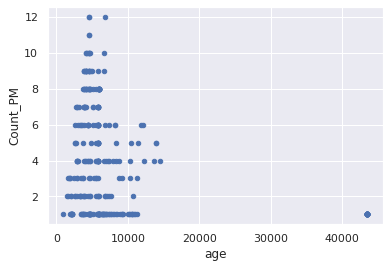

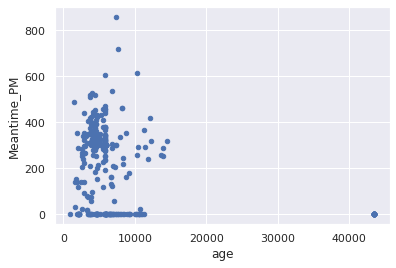

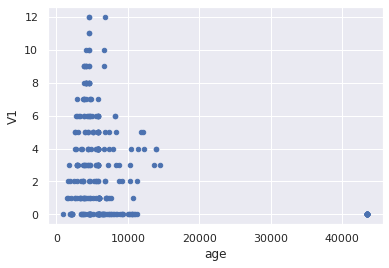

In [31]:
data_anes.plot(x='age',y='Count_PM' ,kind='scatter')
data_anes.plot(x='age',y='Meantime_PM' ,kind='scatter')
data_anes.plot(x='age',y='V1' ,kind='scatter')

In [32]:
data_anes.describe()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age,Label
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,150346.934426,30.750820,10.354098,350.891803,4.144262,209.170492,2.875410,0.318033,0.950820,7962.947541,0.501639
std,162165.661124,0.503482,12.853394,378.951407,3.018393,174.833954,2.989711,0.633886,1.067249,9707.054227,0.500819
min,12000.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,910.000000,0.000000
25%,22500.000000,31.000000,2.000000,68.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4038.000000,0.000000
50%,32700.000000,31.000000,4.000000,249.000000,4.000000,269.000000,2.000000,0.000000,1.000000,5494.000000,1.000000
75%,295000.000000,31.000000,14.000000,528.000000,7.000000,336.000000,5.000000,0.000000,1.000000,6773.000000,1.000000
max,682857.000000,31.000000,62.000000,2058.000000,12.000000,859.000000,12.000000,4.000000,6.000000,43492.000000,1.000000


In [33]:
data_anes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, Anestesiarbetsstation to Lungventilator anestesi
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Equip.reg_date  305 non-null    datetime64[ns]
 1   Scrapped_date   305 non-null    datetime64[ns]
 2   Cost            305 non-null    int64         
 3   Brand           305 non-null    object        
 4   Model           305 non-null    object        
 5   cal.Risk        305 non-null    int64         
 6   Latest_WO       305 non-null    datetime64[ns]
 7   Count_WO        305 non-null    float64       
 8   Meantime        305 non-null    float64       
 9   Latest_PM       305 non-null    datetime64[ns]
 10  Count_PM        305 non-null    float64       
 11  Meantime_PM     305 non-null    float64       
 12  V1              305 non-null    float64       
 13  V2              305 non-null    float64       
 14  V3              305 non

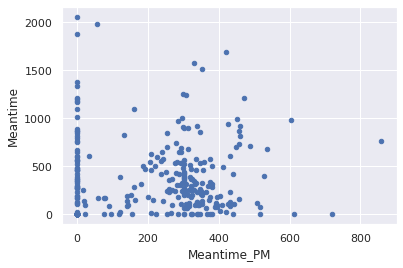

In [34]:
data_anes.plot(x ='Meantime_PM', y='Meantime', kind = 'scatter')	

1.0     99
4.0     33
8.0     29
2.0     28
6.0     28
7.0     20
3.0     20
5.0     19
9.0     16
10.0     8
12.0     3
11.0     2
Name: Count_PM, dtype: int64

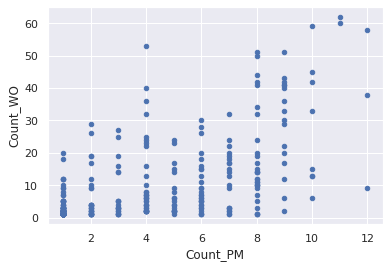

In [35]:
data_anes.plot(x ='Count_PM', y='Count_WO', kind = 'scatter')
data_anes.Count_PM.value_counts()

In [36]:
data_anes.corr()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age,Label
Cost,1.000000,-0.224967,0.465734,-0.194991,0.468358,0.213827,0.324222,0.311287,0.231471,-0.263961,0.148472
cal.Risk,-0.224967,1.000000,-0.526649,0.140578,-0.480607,-0.328516,-0.527684,-0.163154,0.215867,0.139092,-0.128830
Count_WO,0.465734,-0.526649,1.000000,-0.219742,0.599315,0.352969,0.661479,0.018835,-0.169222,-0.194113,0.246726
Meantime,-0.194991,0.140578,-0.219742,1.000000,-0.065539,0.065072,-0.058995,-0.151367,0.069813,-0.179535,-0.726778
Count_PM,0.468358,-0.480607,0.599315,-0.065539,1.000000,0.663199,0.891062,0.292284,0.158444,-0.295485,0.017251
Meantime_PM,0.213827,-0.328516,0.352969,0.065072,0.663199,1.000000,0.618222,0.097548,0.085882,-0.320592,-0.098131
V1,0.324222,-0.527684,0.661479,-0.058995,0.891062,0.618222,1.000000,-0.029360,-0.263784,-0.274581,0.094605
V2,0.311287,-0.163154,0.018835,-0.151367,0.292284,0.097548,-0.029360,1.000000,0.314939,0.265003,0.034619
V3,0.231471,0.215867,-0.169222,0.069813,0.158444,0.085882,-0.263784,0.314939,1.000000,-0.223897,-0.236790
age,-0.263961,0.139092,-0.194113,-0.179535,-0.295485,-0.320592,-0.274581,0.265003,-0.223897,1.000000,0.184660


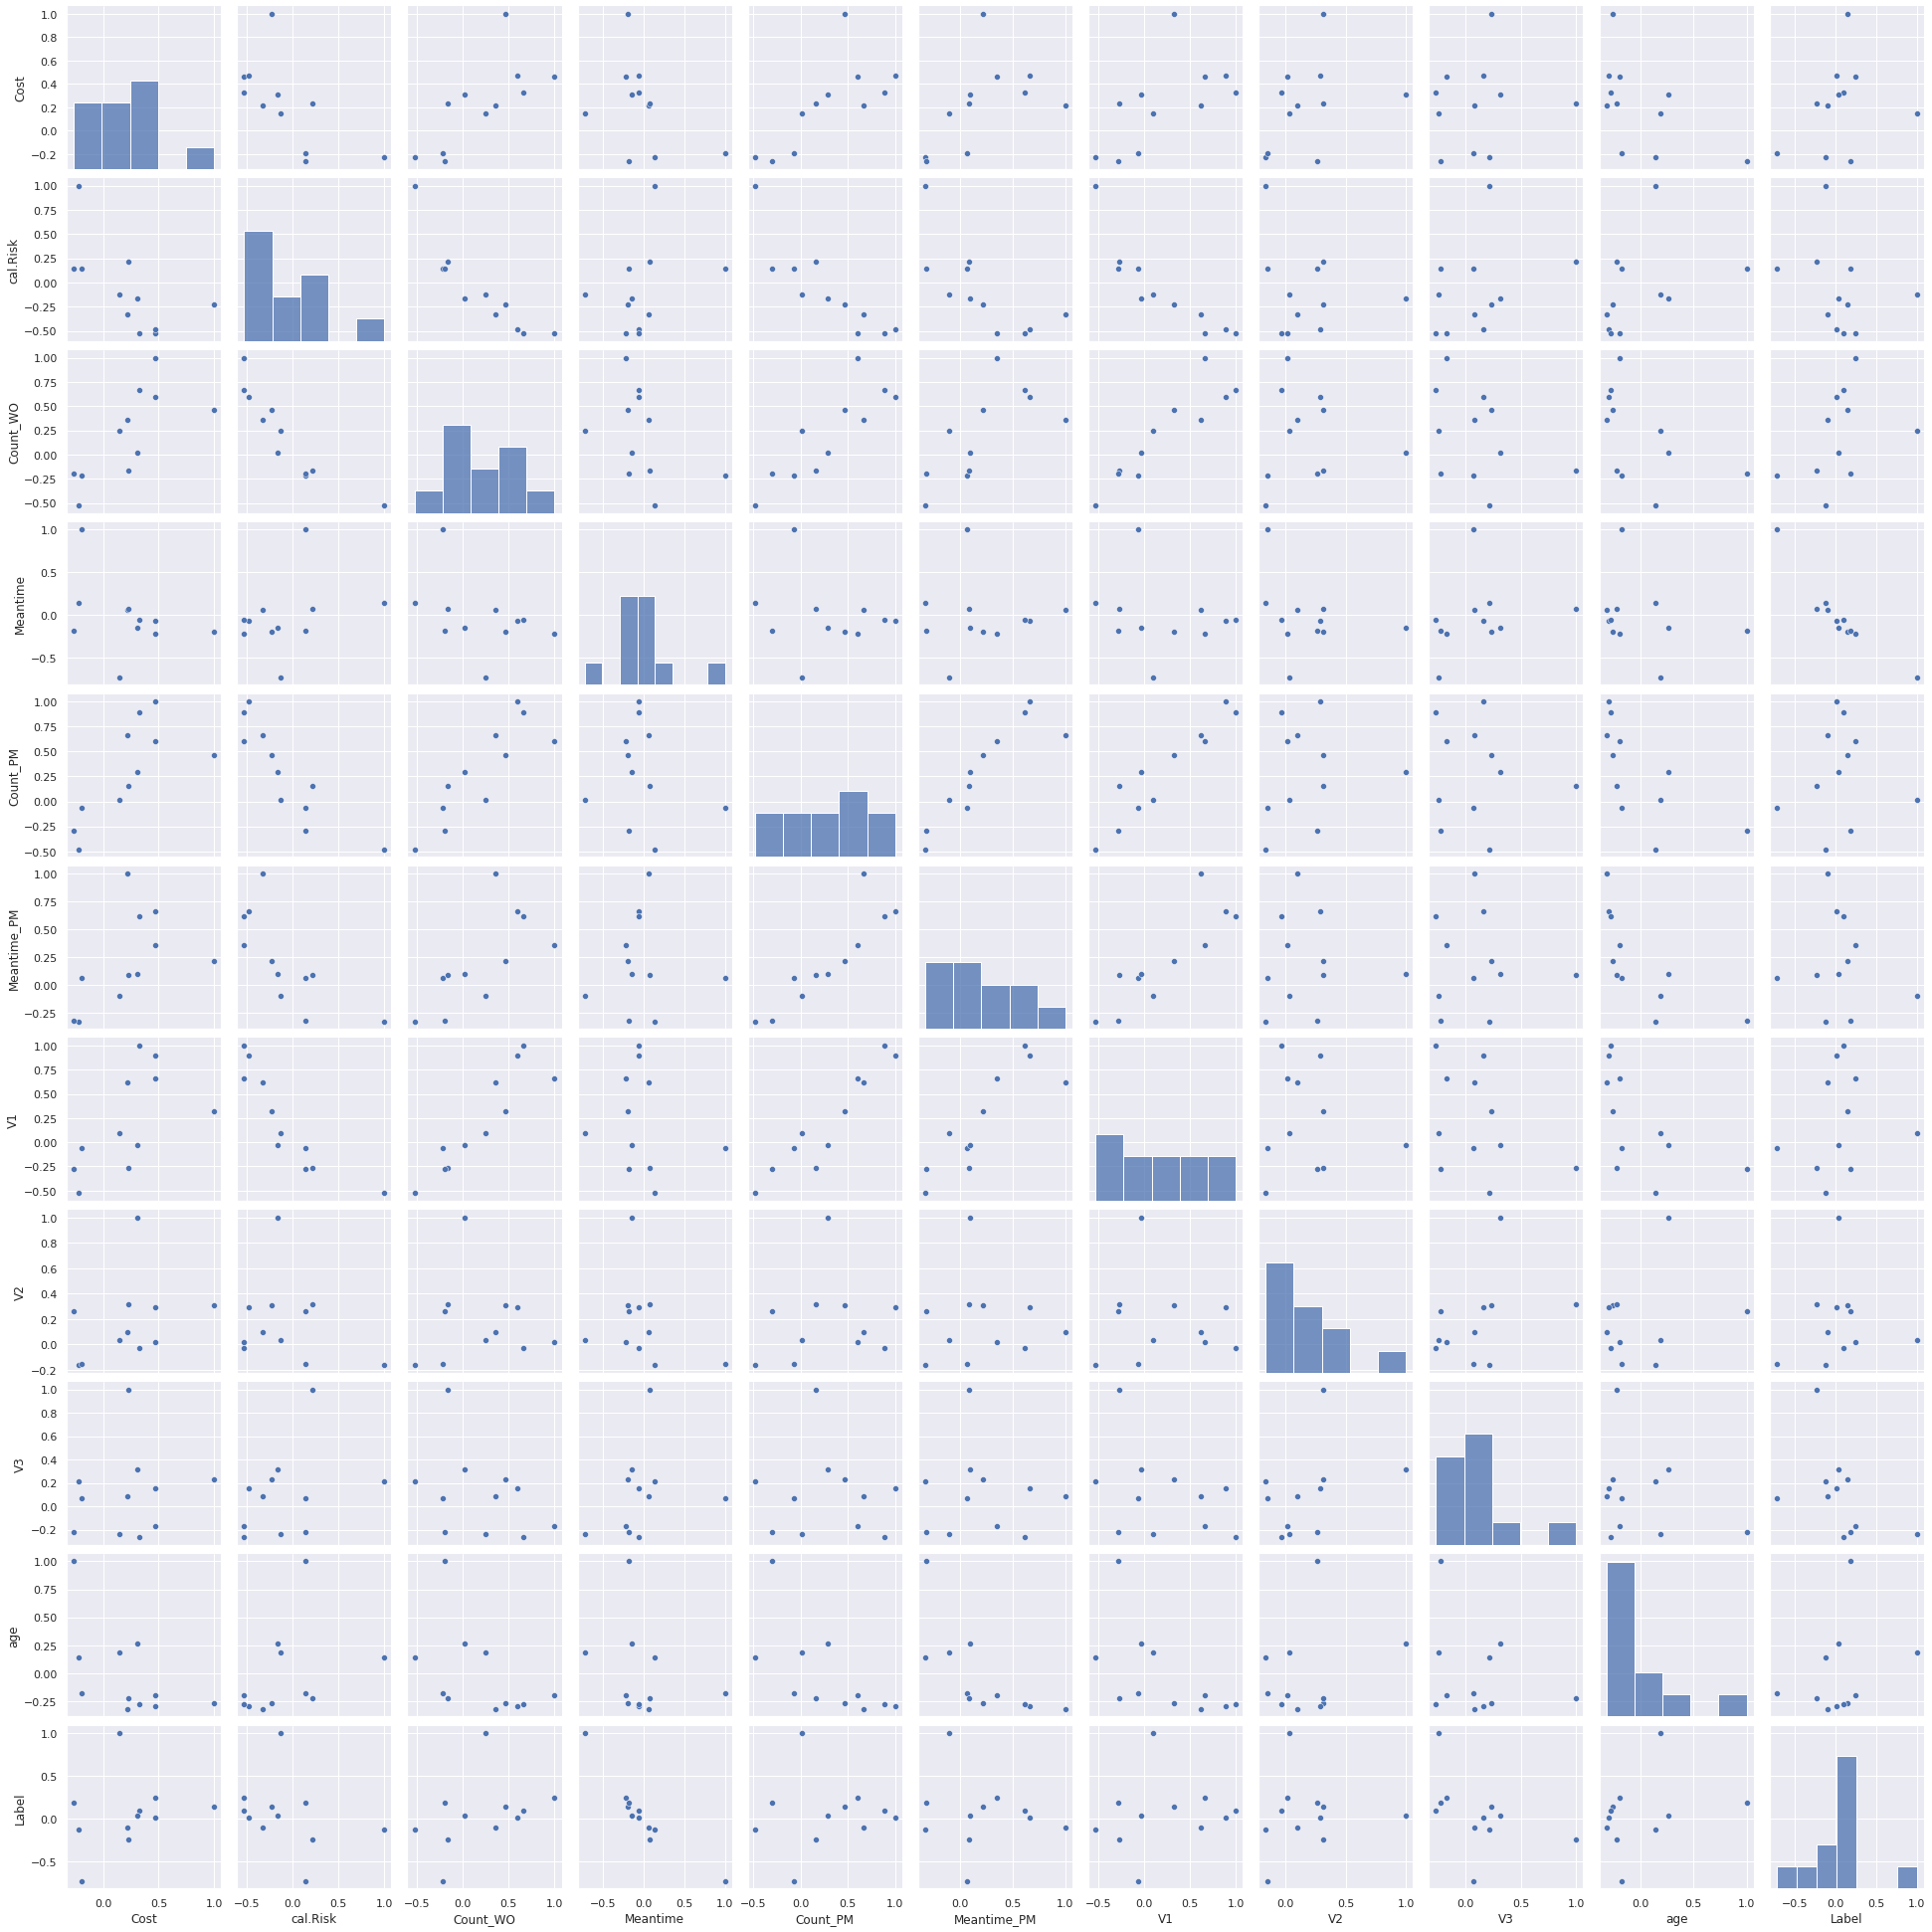

In [37]:
sns.pairplot(data_anes.corr())

# ** Anaesthia with Decision Tree**

In [38]:
pip install -U scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree

In [40]:
X=data_anes.drop(["Label","Equip.reg_date","Scrapped_date","Latest_WO","Latest_PM","Brand","Model","Meantime"],axis=1)
Y=data_anes["Label"].copy()

In [41]:
Y.head(3)

dev
Anestesiarbetsstation    1
Anestesiarbetsstation    0
Anestesiarbetsstation    0
Name: Label, dtype: int64

In [42]:
X.head(3)

,Cost,cal.Risk,Count_WO,Count_PM,Meantime_PM,V1,V2,V3,age
dev,,,,,,,,,
Anestesiarbetsstation,390000,31,1.0,1.0,0.0,1.0,0.0,0.0,3722
Anestesiarbetsstation,390000,31,4.0,2.0,209.0,2.0,0.0,0.0,3722
Anestesiarbetsstation,375000,31,2.0,7.0,297.0,6.0,0.0,1.0,2937


In [43]:
# import export_graphviz
from sklearn.tree import export_graphviz


In [44]:
X_train, X_test, y_train, y_test = train_test_split( 
          X, Y, test_size = 0.2, random_state = 100)

In [45]:
X_test.count()

Cost           61
cal.Risk       61
Count_WO       61
Count_PM       61
Meantime_PM    61
V1             61
V2             61
V3             61
age            61
dtype: int64

In [46]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=5, min_samples_leaf=5)
  

there is a question whether the attributes we have are enough without the textual attributes as the machine learning model needs to deal with numbers 

In [47]:
# Performing training
History=clf_gini.fit(X_train, y_train)

In [48]:
y_pred = History.predict(X_test)
print("Predicted values:")
print(y_pred)

Predicted values:
[0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0]


In [49]:
cm = confusion_matrix(y_test, y_pred)

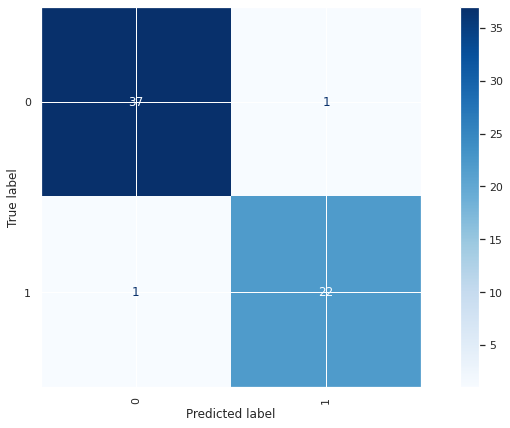

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.gcf().set_size_inches(14,7)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

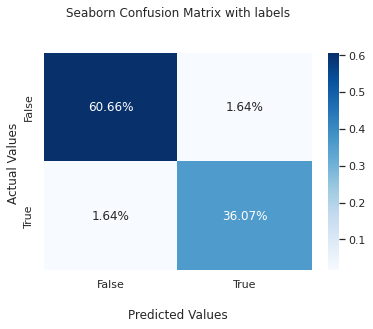

In [51]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [52]:
fn=["Cost","cal.Risk","Count_WO","Count_PM","Meantime_PM","V1","V2","V3","age"]
cn=["1-unhealthy","0healthy"]

[Text(0.4868421052631579, 0.9166666666666666, 'Count_WO <= 1.5\ngini = 0.498\nsamples = 244\nvalue = [114, 130]\nclass = 0healthy'),
 Text(0.4342105263157895, 0.75, 'gini = 0.0\nsamples = 47\nvalue = [0, 47]\nclass = 0healthy'),
 Text(0.5394736842105263, 0.75, 'Count_WO <= 14.5\ngini = 0.488\nsamples = 197\nvalue = [114, 83]\nclass = 1-unhealthy'),
 Text(0.2894736842105263, 0.5833333333333334, 'age <= 3910.0\ngini = 0.353\nsamples = 131\nvalue = [101, 30]\nclass = 1-unhealthy'),
 Text(0.15789473684210525, 0.4166666666666667, 'age <= 3736.0\ngini = 0.496\nsamples = 33\nvalue = [15, 18]\nclass = 0healthy'),
 Text(0.10526315789473684, 0.25, 'age <= 2228.0\ngini = 0.494\nsamples = 27\nvalue = [15, 12]\nclass = 1-unhealthy'),
 Text(0.05263157894736842, 0.08333333333333333, 'gini = 0.375\nsamples = 8\nvalue = [6, 2]\nclass = 1-unhealthy'),
 Text(0.15789473684210525, 0.08333333333333333, 'gini = 0.499\nsamples = 19\nvalue = [9, 10]\nclass = 0healthy'),
 Text(0.21052631578947367, 0.25, 'gini =

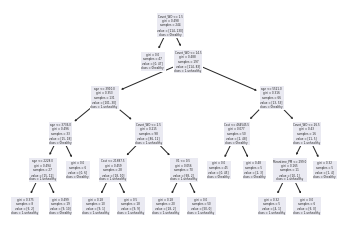

In [53]:
tree.plot_tree(History,feature_names =fn,class_names=cn)

# Patientmonitor multiparameter

In [54]:
data02.head(3)

,Equip.reg_date,Scrapped_date,Cost,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age
dev,,,,,,,,,,,,,,,,
Patientmonitor multiparameter,2010-01-01,2019-10-01,100000,Dräger,Infinity Delta,31,2019-09-25,6.0,111.0,2017-12-18,1.0,0.0,1.0,0.0,0.0,3560
Patientmonitor multiparameter,2010-01-01,2020-06-30,100000,Philips,M8105A IntelliVue MP5,17,2020-06-25,7.0,522.0,2016-04-22,3.0,418.0,3.0,0.0,0.0,3833
Patientmonitor multiparameter,2010-01-01,2018-10-02,100000,Philips,M8105A IntelliVue MP5,31,2018-10-02,4.0,757.0,2018-06-27,4.0,512.0,4.0,0.0,0.0,3196


In [55]:
data02.describe()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
count,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,70912.419266,26.109174,4.506422,484.468807,5.241284,255.358716,4.167890,0.131193,0.942202,4268.927523
std,59407.945689,6.539560,3.832879,461.350892,10.261214,195.863328,6.165328,0.441468,4.754907,1874.673809
min,10650.000000,17.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,772.000000
25%,39536.500000,17.000000,2.000000,128.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3019.000000
50%,62000.000000,31.000000,4.000000,411.000000,4.000000,283.000000,3.000000,0.000000,0.000000,3943.000000
75%,89500.000000,31.000000,6.000000,700.000000,6.000000,380.750000,5.000000,0.000000,1.000000,5242.000000
max,915417.000000,32.000000,42.000000,3143.000000,106.000000,985.000000,52.000000,3.000000,54.000000,13609.000000


In [56]:
data02["Label"]= np.where(data02['Meantime']<=411, 1, 0)
data02.head(5)

,Equip.reg_date,Scrapped_date,Cost,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age,Label
dev,,,,,,,,,,,,,,,,,
Patientmonitor multiparameter,2010-01-01,2019-10-01,100000,Dräger,Infinity Delta,31,2019-09-25,6.0,111.0,2017-12-18,1.0,0.0,1.0,0.0,0.0,3560,1
Patientmonitor multiparameter,2010-01-01,2020-06-30,100000,Philips,M8105A IntelliVue MP5,17,2020-06-25,7.0,522.0,2016-04-22,3.0,418.0,3.0,0.0,0.0,3833,0
Patientmonitor multiparameter,2010-01-01,2018-10-02,100000,Philips,M8105A IntelliVue MP5,31,2018-10-02,4.0,757.0,2018-06-27,4.0,512.0,4.0,0.0,0.0,3196,0
Patientmonitor multiparameter,2009-01-01,2019-03-12,25000,GE Healthcare,Solar 8000,31,2011-10-10,2.0,222.0,2017-06-22,9.0,202.0,9.0,0.0,0.0,3722,1
Patientmonitor multiparameter,2010-01-01,2018-12-27,100000,GE Healthcare,Solar 8000,31,2018-12-21,4.0,436.0,2017-08-10,5.0,400.0,5.0,0.0,0.0,3282,0


measuring the balance of the label to feed the model with later between 0 and 1 labels

In [57]:
data02['Label'].value_counts()

1    545
0    545
Name: Label, dtype: int64

In [58]:
data02.corr()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age,Label
Cost,1.000000,-0.059061,0.153164,0.010612,0.020435,0.063579,0.006950,-0.055786,0.040266,-0.102760,-0.058784
cal.Risk,-0.059061,1.000000,0.000467,-0.003627,0.050034,-0.318673,-0.000706,0.078687,0.101584,0.278074,0.033545
Count_WO,0.153164,0.000467,1.000000,0.015472,0.195931,0.209614,0.231806,-0.031160,0.125153,0.169208,-0.068967
Meantime,0.010612,-0.003627,0.015472,1.000000,0.060633,0.186390,0.093484,0.091858,0.001106,0.181253,-0.728600
Count_PM,0.020435,0.050034,0.195931,0.060633,1.000000,-0.004700,0.954084,0.051589,0.916148,0.065814,-0.099914
Meantime_PM,0.063579,-0.318673,0.209614,0.186390,-0.004700,1.000000,0.098121,0.050983,-0.142103,-0.067314,-0.249694
V1,0.006950,-0.000706,0.231806,0.093484,0.954084,0.098121,1.000000,0.054315,0.757270,0.041052,-0.122225
V2,-0.055786,0.078687,-0.031160,0.091858,0.051589,0.050983,0.054315,1.000000,-0.051941,0.085226,-0.056135
V3,0.040266,0.101584,0.125153,0.001106,0.916148,-0.142103,0.757270,-0.051941,1.000000,0.080886,-0.051926
age,-0.102760,0.278074,0.169208,0.181253,0.065814,-0.067314,0.041052,0.085226,0.080886,1.000000,-0.150374


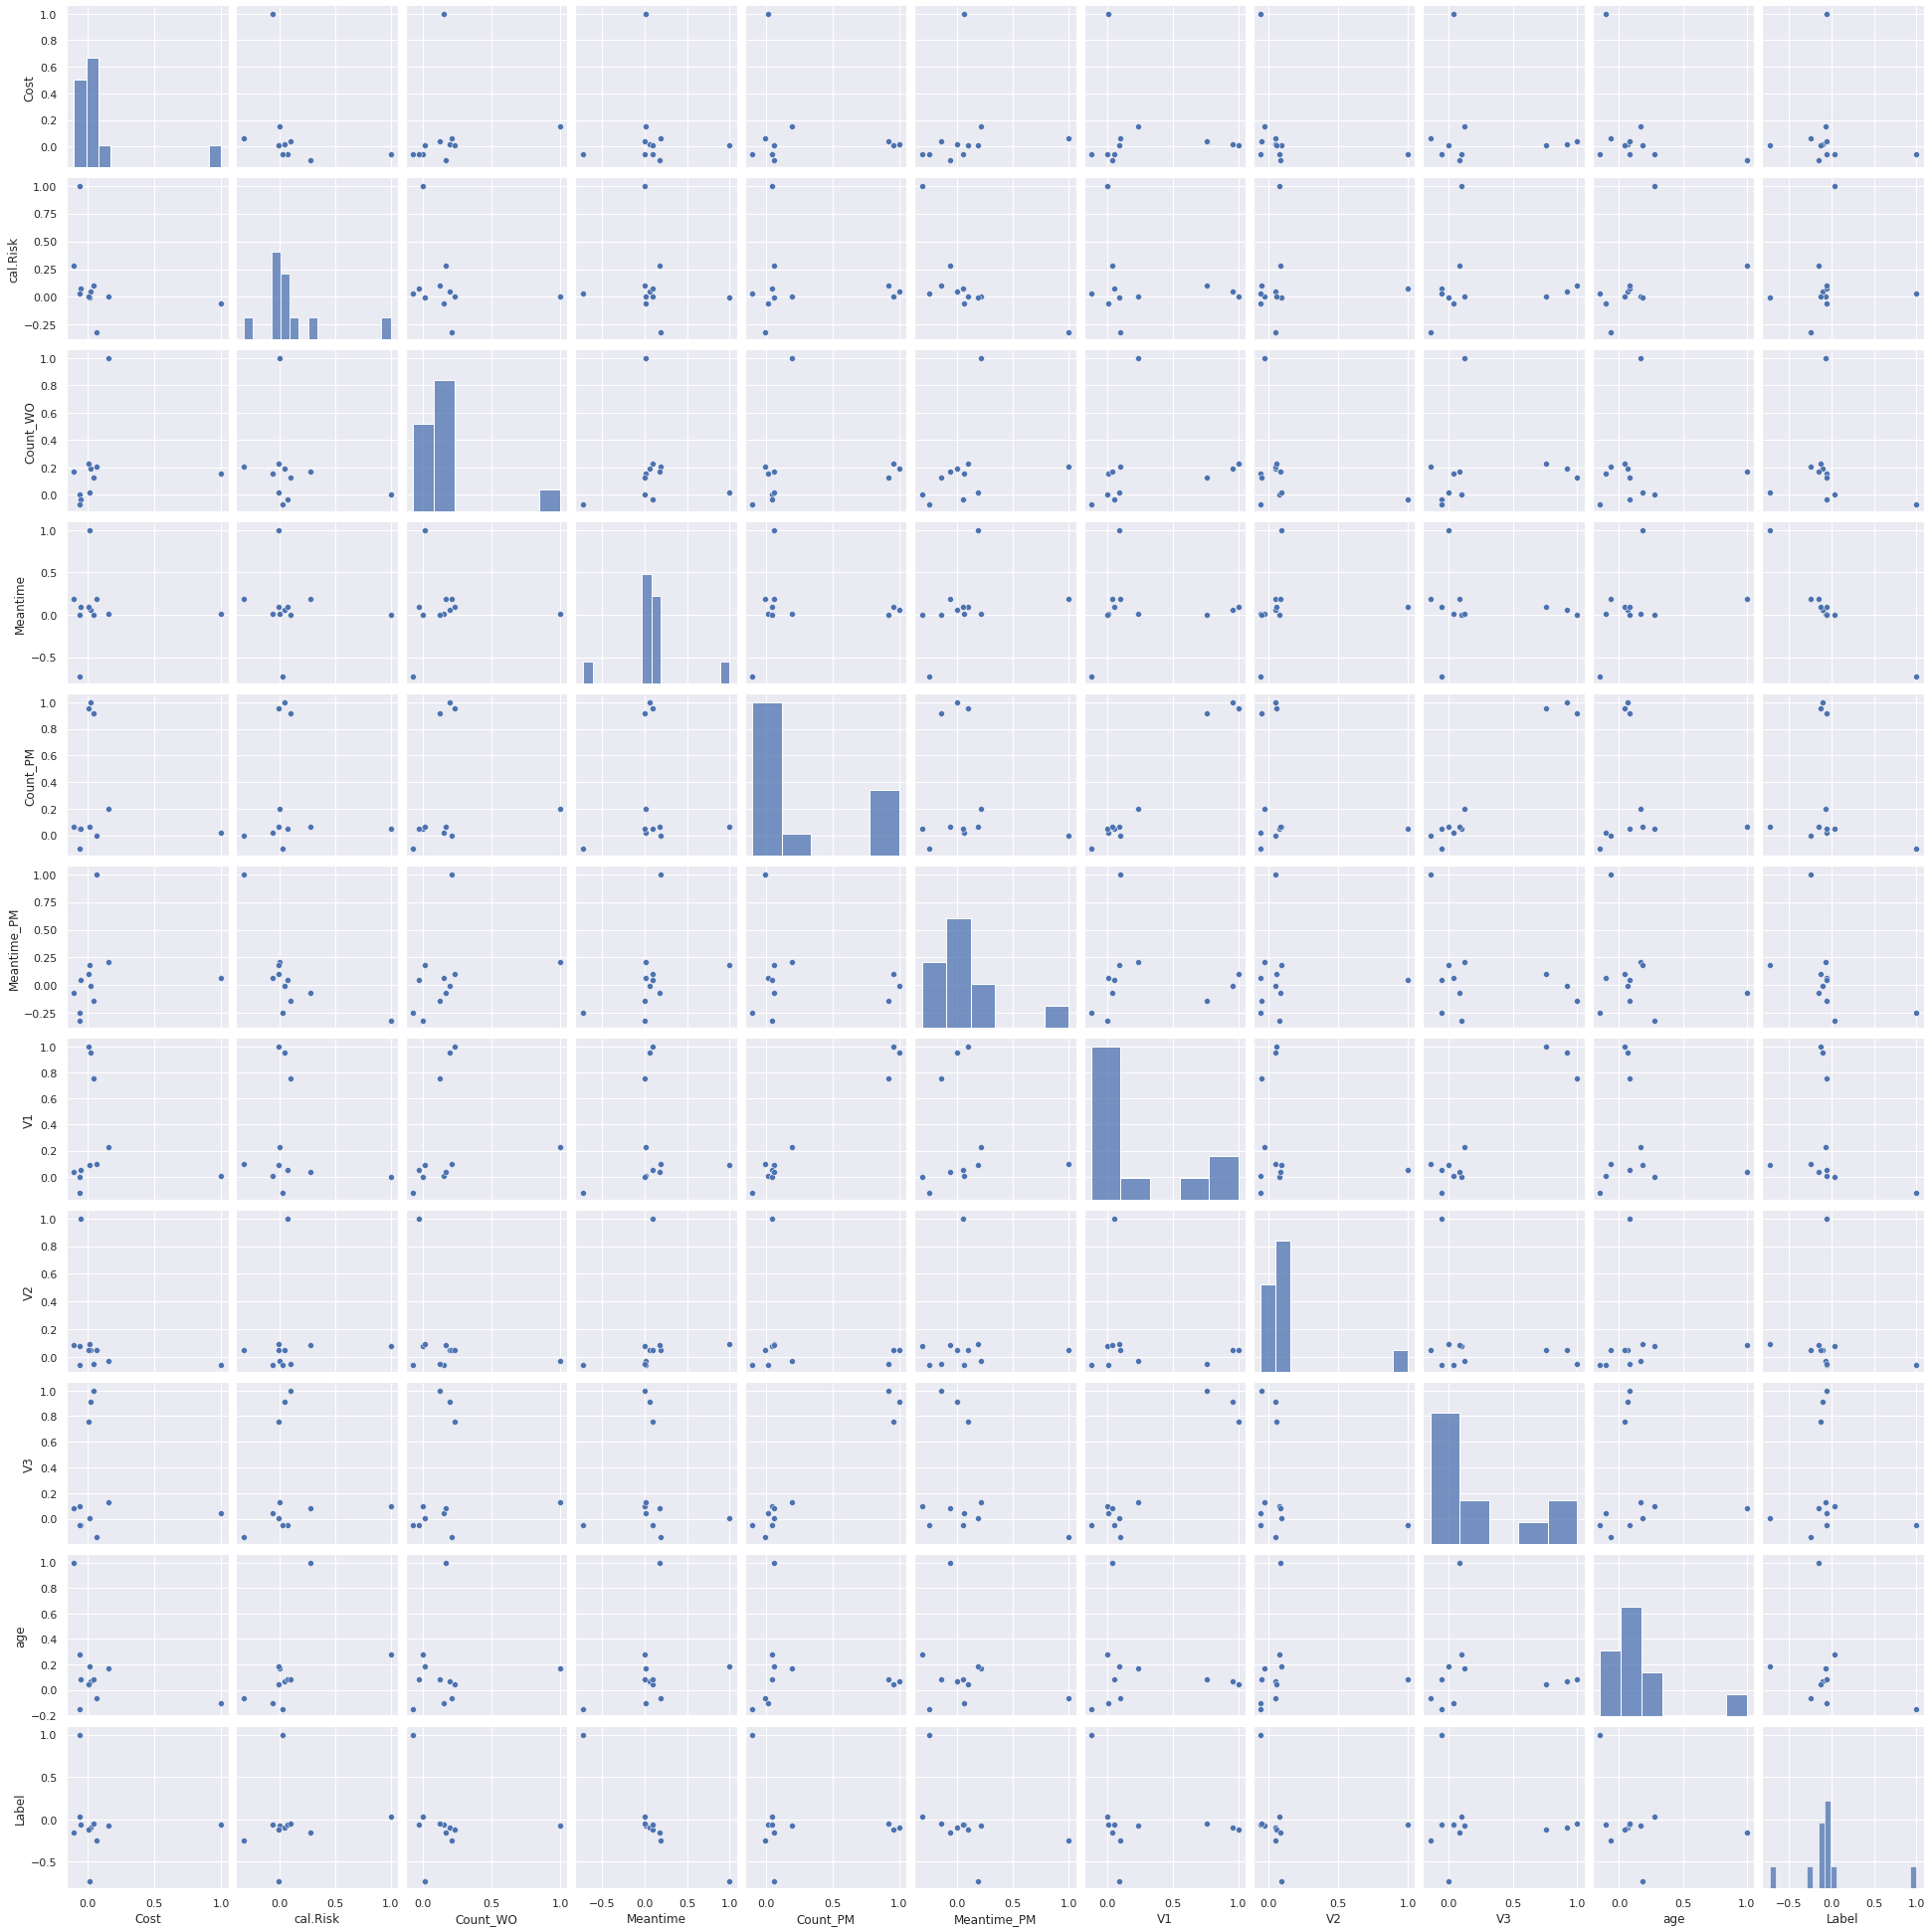

In [59]:
sns.pairplot(data02.corr())

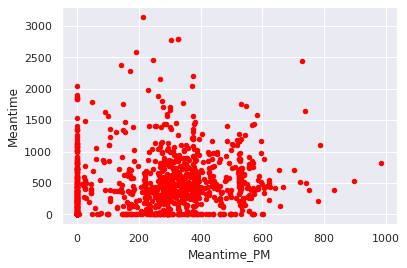

In [60]:
data02.plot(x='Meantime_PM',y='Meantime', kind=('scatter'),color='red')

In [61]:
len(data02)

1090

In [62]:
data02.isnull().sum()

Equip.reg_date    0
Scrapped_date     0
Cost              0
Brand             0
Model             0
cal.Risk          0
Latest_WO         0
Count_WO          0
Meantime          0
Latest_PM         0
Count_PM          0
Meantime_PM       0
V1                0
V2                0
V3                0
age               0
Label             0
dtype: int64

### ML algorithms Applications

In [63]:
X02=data02.drop(["Label","Equip.reg_date","Scrapped_date","Latest_WO","Latest_PM","Brand","Model","Meantime"],axis=1)
Y02=data02["Label"].copy()

In [64]:
Y02.count()

1090

In [65]:
X_train02, X_test02, y_train02, y_test02 = train_test_split( 
          X02, Y02, test_size = 0.3, random_state = 100)

In [66]:
X_test02.count()

Cost           327
cal.Risk       327
Count_WO       327
Count_PM       327
Meantime_PM    327
V1             327
V2             327
V3             327
age            327
dtype: int64

In [67]:
clf_gini02 = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=5, min_samples_leaf=5)


In [68]:
History02=clf_gini02.fit(X_train02, y_train02)

In [69]:
y_pred02 = History02.predict(X_test02)
print("Predicted values:")
print(y_pred)

Predicted values:
[0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0]


In [70]:
cm = confusion_matrix(y_test02, y_pred02)

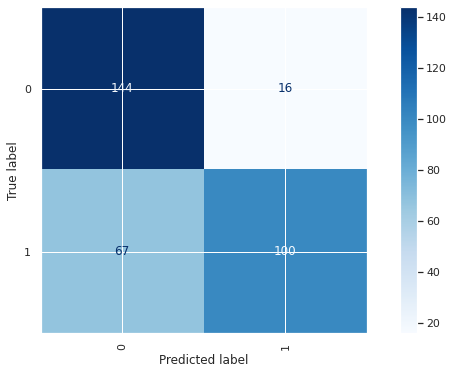

In [71]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.gcf().set_size_inches(12,6)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [72]:
from sklearn.metrics import confusion_matrix

# OXygen *concentrator*

In [73]:
len(data01)

619

In [74]:
data01['age']= (data01['Scrapped_date'] - data01['Equip.reg_date']).dt.days

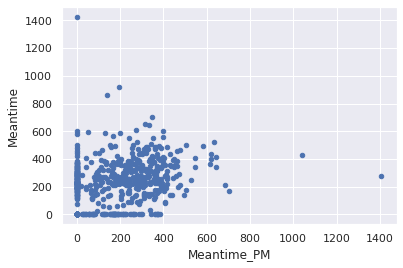

In [75]:
data01.plot(x='Meantime_PM',y=('Meantime'),kind='scatter')

In [76]:
data01.describe()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
count,619.000000,619.0,619.000000,619.000000,619.000000,619.000000,619.000000,619.0,619.0,619.000000
mean,12115.954766,31.0,5.381260,236.101777,2.429725,182.638126,2.429725,0.0,0.0,2301.014540
std,1590.228686,0.0,3.151006,160.386722,1.390963,172.008876,1.390963,0.0,0.0,861.002093
min,11000.000000,31.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,213.000000
25%,11000.000000,31.0,3.000000,142.000000,1.000000,0.000000,1.000000,0.0,0.0,1900.000000
50%,12000.000000,31.0,5.000000,238.000000,2.000000,176.000000,2.000000,0.0,0.0,2330.000000
75%,12400.000000,31.0,8.000000,331.000000,3.000000,308.500000,3.000000,0.0,0.0,2896.500000
max,39000.000000,31.0,14.000000,1426.000000,9.000000,1407.000000,9.000000,0.0,0.0,4799.000000


In [77]:
data01.corr()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
Cost,1.000000,NaN,0.372037,0.182110,-0.168714,-0.097752,-0.168714,NaN,NaN,0.481792
cal.Risk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Count_WO,0.372037,NaN,1.000000,0.305330,-0.126785,-0.075173,-0.126785,NaN,NaN,0.643168
Meantime,0.182110,NaN,0.305330,1.000000,0.077652,0.248589,0.077652,NaN,NaN,0.547415
Count_PM,-0.168714,NaN,-0.126785,0.077652,1.000000,0.448902,1.000000,NaN,NaN,0.138488
Meantime_PM,-0.097752,NaN,-0.075173,0.248589,0.448902,1.000000,0.448902,NaN,NaN,0.256031
V1,-0.168714,NaN,-0.126785,0.077652,1.000000,0.448902,1.000000,NaN,NaN,0.138488
V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,0.481792,NaN,0.643168,0.547415,0.138488,0.256031,0.138488,NaN,NaN,1.000000


In [78]:
data01.head(3)

,Equip.reg_date,Scrapped_date,Cost,Brand,Model,cal.Risk,Latest_WO,Count_WO,Meantime,Latest_PM,Count_PM,Meantime_PM,V1,V2,V3,age
dev,,,,,,,,,,,,,,,,
Oxygenkoncentrator stationär,2003-01-01,2011-09-13,12000,DeVilbiss,515,31,2011-09-12,4.0,331.0,2010-02-08,1.0,0.0,1.0,0.0,0.0,3177
Oxygenkoncentrator stationär,2006-01-01,2012-09-24,13000,Respironics,Millennium M5,31,2012-09-24,7.0,236.0,2011-07-05,1.0,0.0,1.0,0.0,0.0,2458
Oxygenkoncentrator stationär,2004-01-01,2013-06-05,14500,Respironics,Millennium M5,31,2013-06-05,6.0,289.0,2011-07-18,1.0,0.0,1.0,0.0,0.0,3443


In [79]:
data01.describe()

,Cost,cal.Risk,Count_WO,Meantime,Count_PM,Meantime_PM,V1,V2,V3,age
count,619.000000,619.0,619.000000,619.000000,619.000000,619.000000,619.000000,619.0,619.0,619.000000
mean,12115.954766,31.0,5.381260,236.101777,2.429725,182.638126,2.429725,0.0,0.0,2301.014540
std,1590.228686,0.0,3.151006,160.386722,1.390963,172.008876,1.390963,0.0,0.0,861.002093
min,11000.000000,31.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,213.000000
25%,11000.000000,31.0,3.000000,142.000000,1.000000,0.000000,1.000000,0.0,0.0,1900.000000
50%,12000.000000,31.0,5.000000,238.000000,2.000000,176.000000,2.000000,0.0,0.0,2330.000000
75%,12400.000000,31.0,8.000000,331.000000,3.000000,308.500000,3.000000,0.0,0.0,2896.500000
max,39000.000000,31.0,14.000000,1426.000000,9.000000,1407.000000,9.000000,0.0,0.0,4799.000000


In [80]:
data01.isnull().sum()

Equip.reg_date    0
Scrapped_date     0
Cost              0
Brand             0
Model             0
cal.Risk          0
Latest_WO         0
Count_WO          0
Meantime          0
Latest_PM         0
Count_PM          0
Meantime_PM       0
V1                0
V2                0
V3                0
age               0
dtype: int64

In [81]:
data01["Label"]=np.where(data01['Meantime']<=236,1,0)

In [82]:
data01.drop(["Equip.reg_date","Scrapped_date","Latest_WO","Latest_PM","Brand","Model","Meantime"],axis=1)

,Cost,cal.Risk,Count_WO,Count_PM,Meantime_PM,V1,V2,V3,age,Label
dev,,,,,,,,,,
Oxygenkoncentrator stationär,12000,31,4.0,1.0,0.0,1.0,0.0,0.0,3177,0
Oxygenkoncentrator stationär,13000,31,7.0,1.0,0.0,1.0,0.0,0.0,2458,1
Oxygenkoncentrator stationär,14500,31,6.0,1.0,0.0,1.0,0.0,0.0,3443,0
Oxygenkoncentrator stationär,16000,31,7.0,1.0,0.0,1.0,0.0,0.0,4115,0
Oxygenkoncentrator stationär,16000,31,10.0,1.0,0.0,1.0,0.0,0.0,3196,1
...,...,...,...,...,...,...,...,...,...,...
Oxygenkoncentrator stationär,11000,31,1.0,2.0,24.0,2.0,0.0,0.0,367,1
Oxygenkoncentrator stationär,11000,31,1.0,1.0,0.0,1.0,0.0,0.0,367,1
Oxygenkoncentrator stationär,11000,31,1.0,1.0,0.0,1.0,0.0,0.0,378,1


In [83]:
X01=data01.drop(["Label","Equip.reg_date","Scrapped_date","Latest_WO","Latest_PM","Brand","Model","Meantime"],axis=1)
Y01=data01["Label"].copy()

In [84]:
X01.head(3)


,Cost,cal.Risk,Count_WO,Count_PM,Meantime_PM,V1,V2,V3,age
dev,,,,,,,,,
Oxygenkoncentrator stationär,12000,31,4.0,1.0,0.0,1.0,0.0,0.0,3177
Oxygenkoncentrator stationär,13000,31,7.0,1.0,0.0,1.0,0.0,0.0,2458
Oxygenkoncentrator stationär,14500,31,6.0,1.0,0.0,1.0,0.0,0.0,3443


In [85]:
X_train01, X_test01, y_train01, y_test01 = train_test_split( 
          X01, Y01, test_size = 0.3, random_state = 100)

In [86]:
X_train01.count()

Cost           433
cal.Risk       433
Count_WO       433
Count_PM       433
Meantime_PM    433
V1             433
V2             433
V3             433
age            433
dtype: int64

In [87]:
clf_gini02 = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=5, min_samples_leaf=5)


In [88]:
History01=clf_gini02.fit(X_train01, y_train01)

In [89]:
y_pred01 = History01.predict(X_test01)
print("Predicted values:")
print(y_pred)

Predicted values:
[0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0]


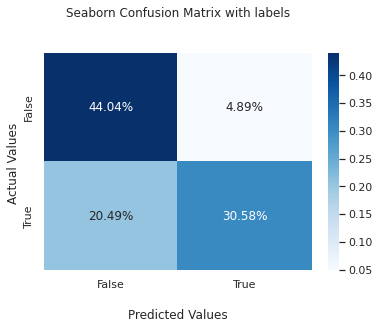

In [90]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [91]:
cm01 = confusion_matrix(y_test01, y_pred01)

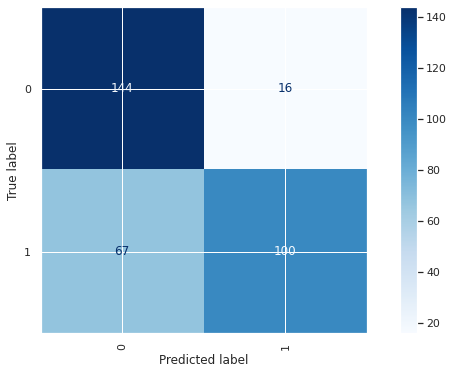

In [92]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.gcf().set_size_inches(12,6)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [93]:
from sklearn.metrics import confusion_matrix

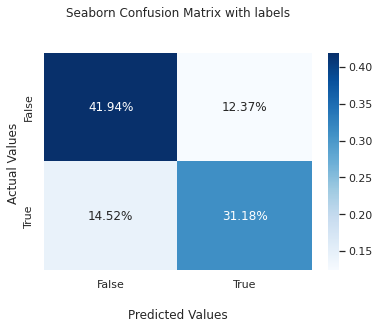

In [94]:
ax = sns.heatmap(cm01/np.sum(cm01), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()